In [ ]:
!pip install opendatagen --upgrade --force-reinstall
!pip install matplotlib

In [ ]:
from opendatagen.data_generator import DataGenerator
from opendatagen.template import TemplateManager


template_file_path = "template.json"
template_name = "humanrights"
output_path = "benchmark.csv"
output_decontaminated_path = None 

manager = TemplateManager(template_file_path=template_file_path)
template = manager.get_template(template_name=template_name)

if template:
        
    generator = DataGenerator(template=template)
    
    data, data_decontaminated = generator.generate_data(output_path=output_path, output_decontaminated_path=output_decontaminated_path)
    

In [13]:
from opendatagen.model import OpenAIEmbeddingModel, OpenAIChatModel
from opendatagen.utils import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt

# Constants
N_FIRST = 3
MIN_WORDS = 200
EMBEDDING_MODELS = [
    ("text-embedding-ada-002", "Text Embedding ada-v2"),
    ("text-embedding-3-small", "Text Embedding 3 small"),
    ("text-embedding-3-large", "Text Embedding 3 large")
]


# Chat Model and Evaluator Model
CHAT_MODEL = OpenAIChatModel(name="gpt-3.5-turbo", temperature=[0], max_tokens=256)
EVALUATOR_MODEL = OpenAIChatModel(name="gpt-4-1106-preview", temperature=[0], max_tokens=64, seed=123)

# Function to split text into chunks of at least n words
def chunk_text(text, min_words):
    words = text.split()
    chunks = [' '.join(words[i:i + min_words]) for i in range(0, len(words), min_words)]
    return chunks

# Function to generate embeddings for each chunk
def generate_embeddings(embedding_model, chunks):
    embeddings_dict = {}
    for chunk in chunks:
        if chunk.strip():
            embeddings_dict[chunk] = embedding_model.create_embedding(prompt=chunk)
    return embeddings_dict

# Read and chunk the text document
with open('document.txt', 'r') as file:
    data = file.read()
chunks = chunk_text(data, MIN_WORDS)

# Generate embeddings for all models
model_embeddings = {}
for model_name, _ in EMBEDDING_MODELS:
    embedding_model = OpenAIEmbeddingModel(name=model_name)
    embeddings_dict = generate_embeddings(embedding_model, chunks)
    model_embeddings[model_name] = embeddings_dict

# Read the benchmark data
df = pd.read_csv("benchmark.csv")


In [ ]:
# Continue with the functions and evaluation from your original code

# Function to find n nearest chunks based on cosine similarity
def n_nearest_chunks(question, embeddings_dict, embedding_model, n):
    question_embedding = embedding_model.create_embedding(prompt=question)
    similarities = {chunk: cosine_similarity(question_embedding, emb) for chunk, emb in embeddings_dict.items()}
    return sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:n]

# Function to process each question, generate an answer, and evaluate the response
def process_questions(df, embeddings_dict, embedding_model):
    true_count = 0
    total_questions = len(df)
    for _, row in df.iterrows():
        question, correct_answer = row['question'], row['answer']
        nearest_chunks = n_nearest_chunks(question, embeddings_dict, embedding_model, N_FIRST)
        content_nearest_chunks = '\n\n'.join([chunk[0] for chunk in nearest_chunks])
        messages = [
            {"role": "system", "content": "Answer the question concisely."},
            {"role": "user", "content": f"Question:\n{question}\nHere is some text that can help you:\n'''\n{content_nearest_chunks}\n'''"}
        ]
        answer = CHAT_MODEL.ask(messages=messages)
        messages_evaluator = [
            {"role": "system", "content": "You are EvaluatorGPT and will say if the Answer is 'True' or 'False' given the 'Correct answer' provided"},
            {"role": "user", "content": f"Answer:\n{answer}\n\nCorrect answer:\n'''\n{correct_answer}\n'''"}
        ]
        evaluation = EVALUATOR_MODEL.ask(messages=messages_evaluator)
        if evaluation.lower().strip() == "true":
            true_count += 1
        else:
            print(evaluation.lower().strip())

    return true_count, total_questions

# Function to evaluate responses for each embedding model
def evaluate_responses(models, df, model_embeddings):
    results = {}
    for model_name, model_label in models:
        embeddings_dict = model_embeddings[model_name]
        embedding_model = OpenAIEmbeddingModel(name=model_name)
        true_count, total_questions = process_questions(df, embeddings_dict, embedding_model)
        results[model_label] = (true_count / total_questions) * 100
    return results

# Evaluation
percentages = evaluate_responses(EMBEDDING_MODELS, df, model_embeddings)




{'Text Embedding ada-v2': 92.85714285714286, 'Text Embedding 3 small': 96.42857142857143, 'Text Embedding 3 large': 92.85714285714286}


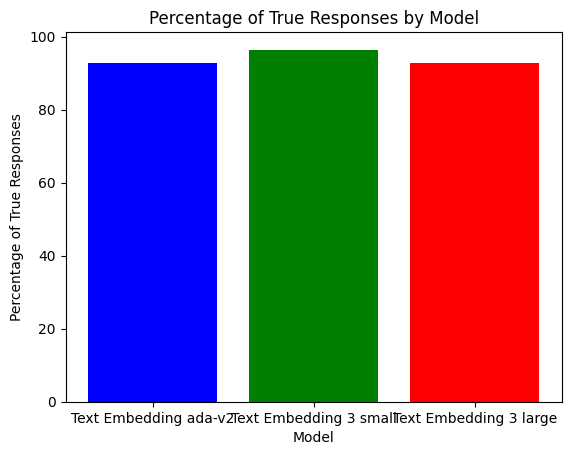

In [15]:
# Plotting

print(percentages)

plt.bar(percentages.keys(), percentages.values(), color=['blue', 'green', 'red'])
plt.title('Percentage of True Responses by Model')
plt.xlabel('Model')
plt.ylabel('Percentage of True Responses')
plt.show()